## Bird Species Prediction

In [1]:
# Set Parameters

# Batch Size for all Datasets
BATCH_SIZE = 64

# Maximum number of Epochs for Training
EPOCHS = 20


In [5]:
# Import Modules
import os
import re
import pandas as pd
import tensorflow as tf
import keras.layers as layers
import matplotlib.pyplot as plt

from keras.models import Model
from keras import regularizers
from sklearn.utils import shuffle
from keras.optimizers import Adamax
from IPython.display import clear_output
from sklearn.preprocessing import LabelEncoder

from callbacks import TrainCallback
from efficient_net import EfficientNet


#### Get Dataset from Kaggle

In [3]:
# Download Dataset
!mkdir dataset
%cd dataset
!kaggle datasets download -d gpiosenka/100-bird-species
clear_output()


In [4]:
# Unzip Dataset
!tar -xf 100-bird-species.zip


In [5]:
# Delete Unwanted Files
!del 100-bird-species.zip
!del "EfficientNetB0-525-(224 X 224)- 98.97.h5"

!rmdir /s/q "train/LOONEY BIRDS" # Not Birds
!rmdir /s/q "test/LOONEY BIRDS"  # Not Birds
!rmdir /s/q "valid/LOONEY BIRDS" # Not Birds

%cd ..
clear_output()


#### Loading Filepaths in Pandas DataFrame

In [6]:
data_df = pd.read_csv('dataset/birds.csv', usecols=['filepaths', 'labels', 'data set'])

data_df = data_df[data_df['labels'] != 'LOONEY BIRDS']  # Not Birds
data_df['filepaths'] = data_df['filepaths'].apply(lambda x: f'dataset/{x}')


#### Cleaning Data

- Some filepaths in dataframe have multiple spaces.
- Some directory names in dataset have multiple spaces
- Typos in Dataframe


In [7]:
# Clean Filepaths
data_df['filepaths'] = data_df['filepaths'].apply(lambda x: re.sub(' +', ' ', x))

data_df['filepaths'] = data_df['filepaths'].apply(lambda x: re.sub('AKULET', 'AUKLET', x))


In [8]:
# Clean Dataset
datasets = os.listdir('dataset')

for dataset in datasets:
    if os.path.isdir(f'dataset/{dataset}'):
        directories = os.listdir(f'dataset/{dataset}')
        for directory in directories:
            new_directory = re.sub(' +', ' ', directory)
            if (new_directory != directory):
                os.rename(f'dataset/{dataset}/{directory}', f'dataset/{dataset}/{new_directory}')


#### Setting Up Data

In [9]:
# Label Encoding
encoder = LabelEncoder().fit(data_df['labels'].unique())
data_df['labels'] = encoder.transform(data_df['labels'])

# Saving encoder data for Web Application
enc_file = open('encoder_data.txt', 'w')
for cls in encoder.classes_:
    enc_file.write(cls+'\n')
enc_file.close()


In [10]:
# Splitting Data
train_df = data_df[data_df['data set'] == 'train']
val_df = data_df[data_df['data set'] == 'valid']
test_df = data_df[data_df['data set'] == 'test']


In [11]:
# Sampling 128 Images from each class
train_df = shuffle(train_df.groupby('labels', group_keys=False).apply(lambda x: x.sample(n=128)))


In [12]:
# Creating Dataset
def load_dataframe(df):
    ds = tf.data.Dataset.from_tensor_slices((df['filepaths'], df['labels']))
    ds = ds.map(lambda x, y: (tf.io.read_file(x), y), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    ds = ds.map(lambda x, y: (tf.image.decode_jpeg(x, channels=3), y), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    ds = ds.map(lambda x, y: (tf.image.resize(x, (224, 224)), y), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    ds = ds.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

    # Optimize Performance
    ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds


train_ds = load_dataframe(train_df)
val_ds = load_dataframe(val_df)
test_ds = load_dataframe(test_df)


#### Modelling

In [13]:
# Preprocessing Layers
scaling_layer = layers.Rescaling(1.0/255)
normalizing_layer = layers.Normalization()

ds = tf.data.Dataset.from_tensor_slices((train_df['filepaths']))
ds = ds.map(lambda x: tf.io.read_file(x), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
ds = ds.map(lambda x: tf.image.decode_jpeg(x, channels=3), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
ds = ds.map(lambda x: tf.image.resize(x, (224, 224)), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
ds = ds.map(lambda x: scaling_layer(x), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

normalizing_layer.adapt(ds, batch_size=BATCH_SIZE)


In [14]:
# Build Model
input = tf.keras.Input(shape=(224, 224, 3), name='Input_Layer')
output = scaling_layer(input)
output = normalizing_layer(output)

output = EfficientNet(output)  # EfficientNet B0

output = layers.BatchNormalization()(output)
output = layers.Dense(524, kernel_regularizer=regularizers.l2(l=0.015), activity_regularizer=regularizers.l1(0.005),
                      bias_regularizer=regularizers.l1(0.005), activation='softmax')(output)

model = Model(inputs=input, outputs=output)

model.compile(Adamax(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [15]:
# Training Model
callback = TrainCallback(model, EPOCHS, epoch_patience=2, lr_patience=2)
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=2, callbacks=[callback])


Epoch 1/20
1048/1048 - 367s - loss: 7.5608 - accuracy: 0.0268 - val_loss: 5.7382 - val_accuracy: 0.0790 - 367s/epoch - 350ms/step
Epoch 2/20
1048/1048 - 429s - loss: 4.2936 - accuracy: 0.2701 - val_loss: 3.3497 - val_accuracy: 0.4015 - 429s/epoch - 410ms/step
Epoch 3/20
1048/1048 - 461s - loss: 2.7274 - accuracy: 0.5612 - val_loss: 2.2224 - val_accuracy: 0.6519 - 461s/epoch - 440ms/step
Epoch 4/20
1048/1048 - 455s - loss: 1.9528 - accuracy: 0.7180 - val_loss: 1.8175 - val_accuracy: 0.7282 - 455s/epoch - 434ms/step
Epoch 5/20
1048/1048 - 452s - loss: 1.4738 - accuracy: 0.8156 - val_loss: 1.6355 - val_accuracy: 0.7588 - 452s/epoch - 432ms/step
Epoch 6/20
1048/1048 - 461s - loss: 1.1233 - accuracy: 0.8878 - val_loss: 1.5202 - val_accuracy: 0.7664 - 461s/epoch - 440ms/step
Epoch 7/20
1048/1048 - 457s - loss: 0.8479 - accuracy: 0.9428 - val_loss: 1.4227 - val_accuracy: 0.7691 - 457s/epoch - 436ms/step
Epoch 8/20
1048/1048 - 457s - loss: 0.6487 - accuracy: 0.9745 - val_loss: 1.2420 - val_acc

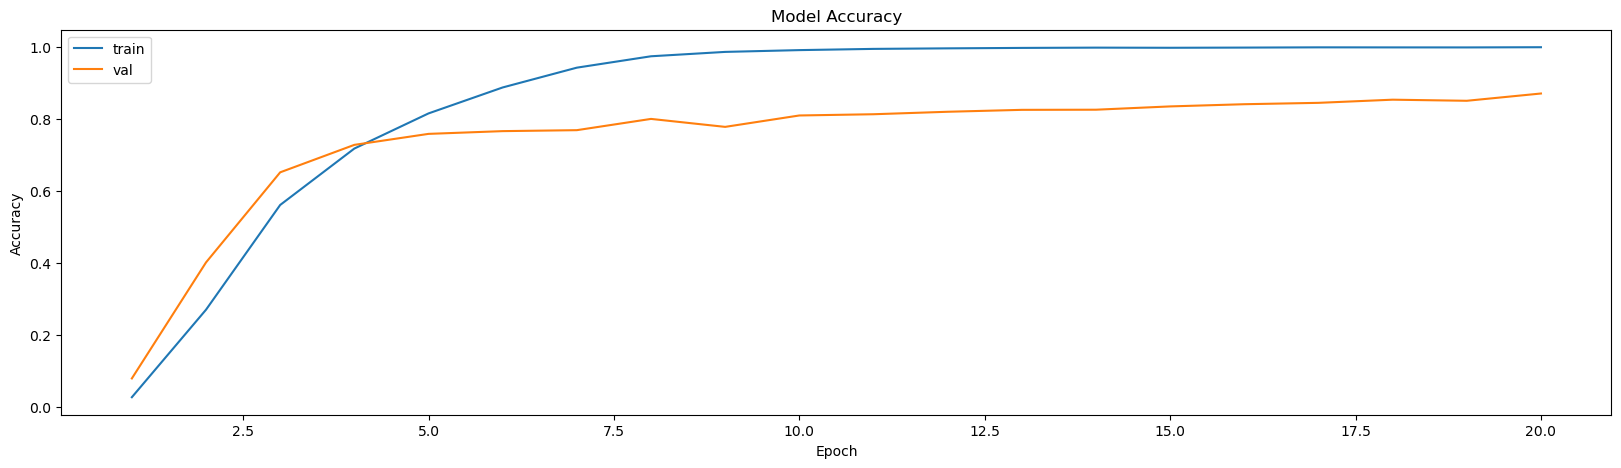

In [16]:
# Plot the training history
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label='train')
ax.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label='val')
_ = ax.legend()


#### Model Evaluation

In [17]:
# Model Accuracy on Test Data
score = model.evaluate(test_ds)
print(f'Accuracy over the test set: {round((score[1]*100), 2)}%')


41/41 [==============================] - 6s 135ms/step - loss: 0.4815 - accuracy: 0.9141
Accuracy over the test set: 91.41%


In [18]:
model.save('model.h5')
